In [1]:
from datasets_util import DatasetsUtil

data_utils = DatasetsUtil()

# Excract required labels 

In [2]:
# Excracting all the required labels from the annotations.

# Please note, dataset_i is the dataset index:
#        0              1              2           3         4
# "caltech_cars", "english_lp", "open_alpr_eu", "aolp", "ufpr_alpr"

dataset_labels = data_utils.get_all_labels(dataset_i=0, print_log=0)

# Visualise dataset and its labels/annotations

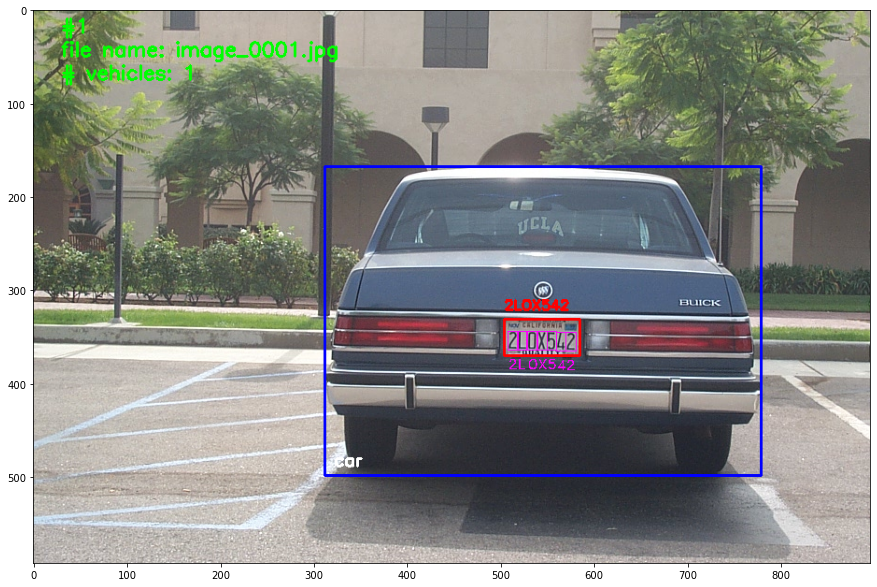

In [3]:
# Plotting images with all the labels to visualise and ensure everything is good.
data_utils.visualise_dataset(dataset_i=0)  # Use the letters "a" and "d" to change sample, "q" to quit.